In [1]:
# Load filter2D + dilate overlay
from pynq import Overlay
bareHDMI = Overlay("/usr/local/lib/python3.6/dist-packages/"
               "pynq_cv/overlays/xv2Filter2DDilate.bit")
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory mangager
from pynq import Xlnk
Xlnk.set_allocator_library("/usr/local/lib/python3.6/dist-packages/"
                           "pynq_cv/overlays/xv2Filter2DDilate.so")
mem_manager = Xlnk()

hdmi_in = bareHDMI.video.hdmi_in
hdmi_out = bareHDMI.video.hdmi_out

In [2]:
from pynq.lib.video import *
hdmi_in.configure(PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

mymode = hdmi_in.mode
print("My mode: "+str(mymode))

My mode: VideoMode: width=1920 height=1080 bpp=8


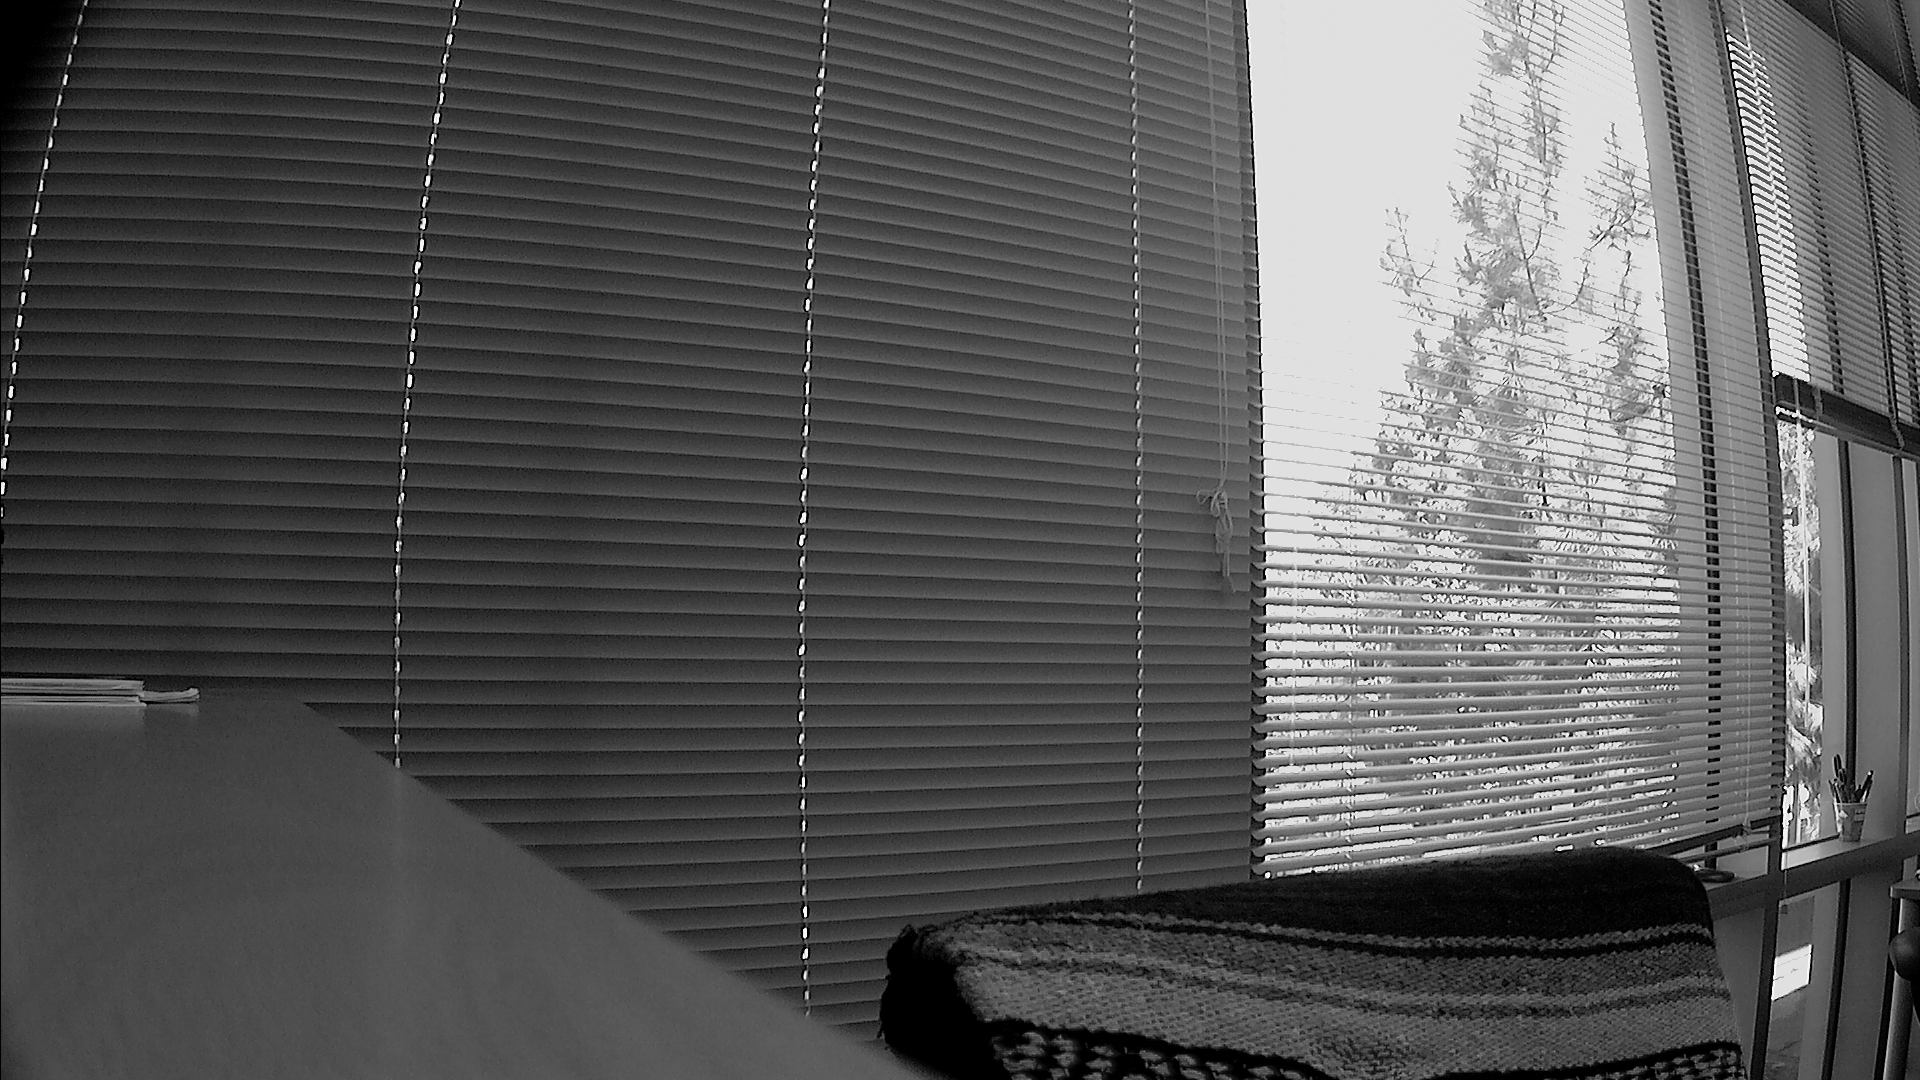

In [3]:
height = hdmi_in.mode.height
width = hdmi_in.mode.width
bpp = hdmi_in.mode.bits_per_pixel

inframe = hdmi_in.readframe()
outframe = hdmi_out.newframe()
hdmi_out.writeframe(inframe)

import PIL.Image

image = PIL.Image.fromarray(inframe)
image

In [6]:
import numpy as np
import cv2

reference_blur = cv2.GaussianBlur(inframe, (5, 5), 0)
kernelVoid = np.zeros(0)
#dilated = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)
blur = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)
numframes = 200
outframe = hdmi_out.newframe()
kernel_g =  np.array([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]],np.float32)
xBbuf = mem_manager.cma_array((height,width),np.uint8)
xDbuf = mem_manager.cma_array((height,width),np.uint8)
xTbuf = mem_manager.cma_array((height,width),np.uint8)
grey = hdmi_in.readframe()   
xv2.filter2D(grey, -1, kernel_g, dst=xBbuf, borderType=cv2.BORDER_CONSTANT)
difference = cv2.absdiff(reference_blur, xBbuf)
threshold = cv2.threshold(difference, 32, 255, cv2.THRESH_BINARY)[1]
#mem_manager.cma_memcopy(xTbuf, threshold, threshold.size)
#xTbuf
#xTbuf.size






In [5]:
#while(True):
import time



start = time.time()    
for _ in range(numframes):
    grey = hdmi_in.readframe()   
    xv2.filter2D(grey, -1, kernel_g, dst=xBbuf, borderType=cv2.BORDER_CONSTANT)
    difference = xv2.absdiff(reference_blur, xBbuf)
    threshold = xv2.threshold(difference, 85, 255, cv2.THRESH_BINARY)[1]
    mem_manager.cma_memcopy(xTbuf, threshold, threshold.size)
    xv2.dilate(xTbuf, kernelVoid, dst=xDbuf, iterations=1, borderType=cv2.BORDER_CONSTANT)
    _, contours, hier = cv2.findContours(xDbuf.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in contours:
        #print(i)
        contourArea = cv2.contourArea(i)
        if contourArea < 17500 or contourArea > 35000:
            continue
        (x, y, w, h) = cv2.boundingRect(i)
        cv2.rectangle(grey, (x, y), (x + w, y + h), (0, 0, 255), 2) 
        hdmi_out.writeframe(grey)
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

xBbuf.close()
xDbuf.close()
xTbuf.close()
hdmi_out.close()
hdmi_in.close()

Frames per second:  2.1918136134859654


ModuleNotFoundError: No module named 'pynq_computervision'